# Procesowanie obrazów siatkówki oka w celu identyfikacji 

Do przeprowadzenia analizy skorzystamy z datasetu STARE(STructured Analysis of the REtina) zawierajacego obrazy 397 siatkówek. Pliki w datasecie zapisane sa w formacie ppm(portable pixmap) co oznacza ze nie sa one skompresowane, caly dataset ma ponad 500 mb wiec dla wygody skorzystamy tylko ze 150 obrazów. Zamierzmay wykorzystac techniki procesowania sygnałow do przetwozenia siatkówek i pokazania że są unikalne dla kazdego człowieka. W tym celu wykorzsystamy wykrywanie krawedzi oraz korelacji aby pokazac ze siatkówka jest unikalna.

In [2]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.signal as ss 
import scipy.ndimage as sn 
from PIL import Image
import cv2

In [3]:
folder_path = "data/archive"
image_paths = []

for filename in os.listdir(folder_path):
    if filename.endswith(".ppm"):
        image_paths.append(os.path.join(folder_path, filename))

# Store image paths in a CSV
df = pd.DataFrame(image_paths, columns=["img"])

## Obrazy jakie znajduja sie w STARE dataset 

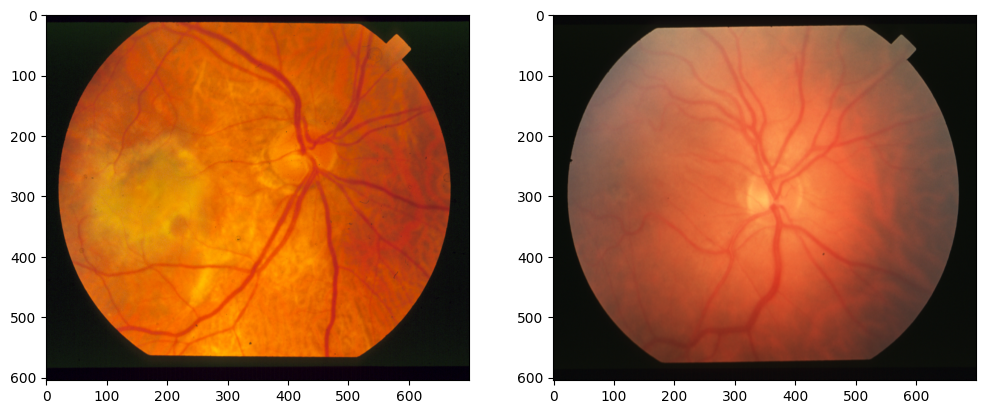

In [4]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

img1=Image.open(df["img"][0])
ax1.imshow(img1)

img2=Image.open(df["img"][64])
ax2.imshow(img2)

plt.show()

# Proces przetwarzania obrazów

## Konwersja w skale szarości 

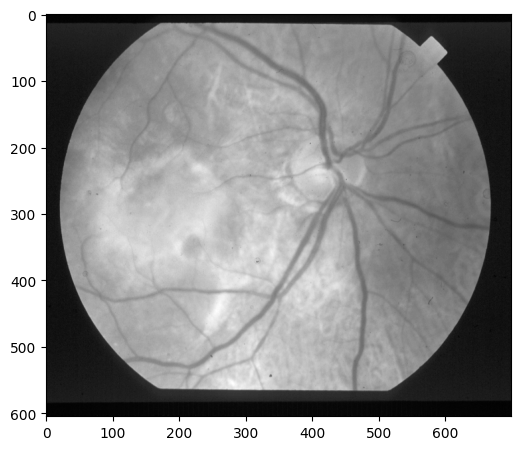

In [24]:
imgs_gray = []
for i in range(len(df)):
    imgs_gray.append(cv2.imread(df["img"][i],cv2.IMREAD_GRAYSCALE))

plt.figure(figsize=(6,6))
plt.imshow(imgs_gray[0],cmap="gray")
plt.show()


## Gausowskie rozmycie (*Gaussian Blur*)

### Matematyczna Definicja:

Gaussian blur opiera się na funkcji rozkładu Gaussa, której wzór jest następujący:

$
G(x, y) = \frac{1}{2 \pi \sigma^2} \cdot \exp\left(-\frac{x^2 + y^2}{2 \sigma^2}\right)
$

Gdzie:
- $G(x, y)$ to wartość funkcji Gaussa w punkcie \( (x, y) \)
- $\sigma$ to odchylenie standardowe, które kontroluje "rozmycie" (większe $ \sigma$ oznacza silniejsze rozmycie)
- $ x $ i $ y $ to współrzędne punktu względem środka filtra

**Proces wygładzania** obrazu polega na **konwolucji** obrazu z filtrem Gaussa. Oznacza to, że dla każdego piksela w obrazie oblicza się średnią ważoną z pikseli wokół niego, gdzie wagi są zależne od funkcji Gaussa.

Formuła dla konwolucji obrazu $I$ z filtrem Gaussa wygląda następująco:

$
I_{\text{blurred}}(x, y) = \sum_{i=-k}^{k} \sum_{j=-k}^{k} I(x+i, y+j) \cdot G(i, j)
$

Gdzie:
- $I(x, y)$ to wartość piksela w oryginalnym obrazie
- $G(i, j)$ to wartość wagi z funkcji Gaussa
- $k$ to promień okna filtra (zwykle rozmiar filtra to $(2k+1) \times (2k+1)$ 

Przykładowy filtr Gaussa  $3 \times 3$  dla  $\sigma = 1$ :


\begin{bmatrix}
0.0751 & 0.1238 & 0.0751 \\
0.1238 & 0.2042 & 0.1238 \\
0.0751 & 0.1238 & 0.0751
\end{bmatrix}

**Proces wygładzania** zwizualizowany poniżej obrazuje działanie matematycznych założeń filtra gausa na przykładzie małego obrazu, wartosci z macierzy filtra zostały zaokraglone do dwóch miejsc po przecinku




<img src="imgs/blurrgif.gif" alt="segment" title="SegemntLocal" width="900" height="450"/>

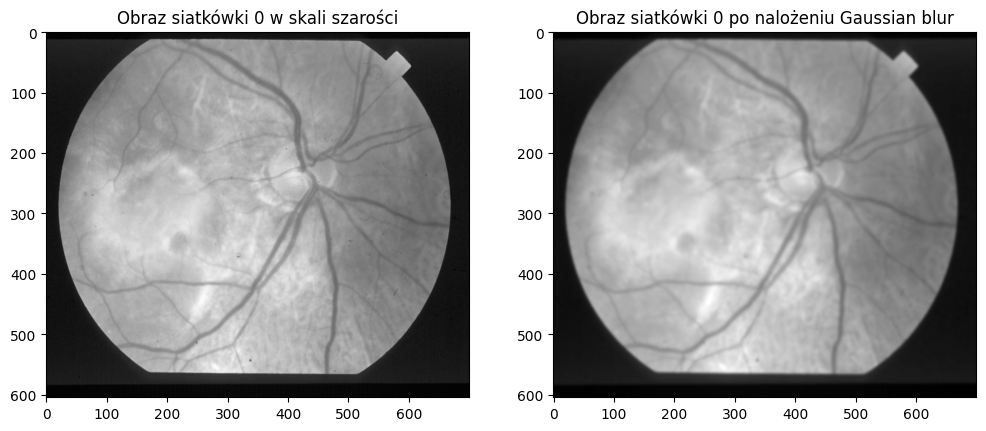

In [52]:
blurred_imgs=[]
for i in range(len(df)):
    blurred_imgs.append(cv2.GaussianBlur(imgs_gray[i],(11,11),2))

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.imshow(imgs_gray[0],cmap="gray")
ax1.set_title("Obraz siatkówki 0 w skali szarości")

ax2.imshow(blurred_imgs[0],cmap="gray")
ax2.set_title("Obraz siatkówki 0 po nalożeniu Gaussian blur")

plt.show()


## Wykrywanie krawędzi(algorytm Canny)

### 1. Gradienty

#### a) Obliczenie gradientów $G_x$ i $G_y$
Gradient obrazu mierzy zmianę jasności pikseli. Wykorzystuje się **operator Sobela**, aby obliczyć gradient w kierunkach poziomym $(x)$ i pionowym $(y)$. Gradienty w kierunku poziomym i pionowym są obliczane za pomocą splotu obrazu $I(x, y)$ z maskami Sobela:

- **Maski Sobela**:
  $
  S_x = \begin{bmatrix}
  -1 & 0 & 1 \\
  -2 & 0 & 2 \\
  -1 & 0 & 1
  \end{bmatrix}, \quad
  S_y = \begin{bmatrix}
  -1 & -2 & -1 \\
   0 &  0 &  0 \\
   1 &  2 &  1
  \end{bmatrix}
  $

- **Splot obrazu**:
  $
  G_x = I(x, y) * S_x, \quad G_y = I(x, y) * S_y
  $

### b) Wielkość gradientu $G$
Wielkość gradientu określa intensywność zmiany jasności:

$
G = \sqrt{G_x^2 + G_y^2}
$

### c) Kierunek gradientu $\theta$
Kierunek gradientu wskazuje orientację krawędzi:
$
\theta = \arctan\left(\frac{G_y}{G_x}\right)
$

Aby uprościć obliczenia, kierunek gradientu $\theta$ jest zaokrąglany do jednej z czterech orientacji:
- $0^\circ $
- $45^\circ$ 
- $90^\circ$ 
- $135^\circ$ 

---

### 3. Niejednoznaczne tłumienie (*Non-Maximum Suppression*)

Celem tego kroku jest usunięcie pikseli, które nie są lokalnymi maksimami gradientu, aby uzyskać bardziej wyraźne krawędzie.

#### a) Porównanie gradientu z sąsiadami
Dla każdego piksela $(x, y)$:
1. Wyznacz kierunek gradientu (zaokrąglony do jednej z 4 orientacji).
2. Porównaj wartość gradientu $G(x, y)$ z wartością gradientu sąsiadów **w kierunku gradientu**:
   - Jeśli $\theta \approx 0^\circ$: Porównanie z pikselami w osi $x$.
   - Jeśli $\theta \approx 45^\circ$: Porównanie z pikselami po przekątnej (lewy górny i prawy dolny).
   - Jeśli $\theta \approx 90^\circ$: Porównanie z pikselami w osi $y$.
   - Jeśli $\theta \approx 135^\circ$: Porównanie z pikselami po przekątnej (lewy dolny i prawy górny).

#### b) Eliminacja pikseli
Jeśli wartość gradientu $G(x, y)$ nie jest większa od sąsiadów w kierunku gradientu, wartość \( G(x, y) \) jest ustawiana na \( 0 \):

$
G'(x, y) =
\begin{cases}
G(x, y), & \text{jeśli } G(x, y) > G(x_1, y_1) \text{ i } G(x, y) > G(x_2, y_2) \\
0, & \text{w przeciwnym razie.}
\end{cases}
$

---

### 4. Podwójne progowanie (*Double Thresholding*)
Celem progowania jest okreslenie czy dany piksel jest istotny czy nie 

#### a) Klasyfikacja pikseli
Każdy piksel jest klasyfikowany na podstawie wartości gradientu $G'(x, y)$ i porównywany z narzuconymi wartościami tolerancji:
- **Silne krawędzie**: $G'(x, y) > T_{\text{high}}$
- **Słabe krawędzie**: $T_{\text{low}} < G'(x, y) \leq T_{\text{high}}$
- **Inne piksele**: $G'(x, y) \leq T_{\text{low}}$

#### b) Efekt progowania
- Silne krawędzie są bezpośrednio uwzględniane.
- Słabe krawędzie są uwzględniane tylko, jeśli sąsiadują z silnymi krawędziami.
- Inne piksele są ignorowane.

---

### 5. Histereza (*Edge Tracking by Hysteresis*)

#### a) Łączenie krawędzi
- Słabe piksele są iteracyjnie sprawdzane:
  - Jeśli słaby piksel sąsiaduje z silnym pikselem, zostaje oznaczony jako krawędź.
  - W przeciwnym razie jest ignorowany.

Matematycznie:

$
E(x, y) =
\begin{cases}
1, & \text{jeśli piksel należy do silnej krawędzi lub łączy się z nią} \\
0, & \text{w przeciwnym razie.}
\end{cases}
$


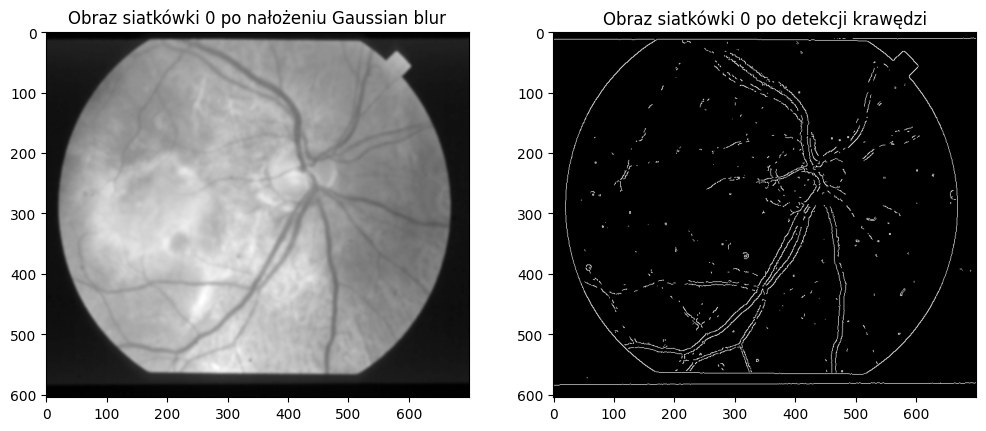

In [ ]:
edge_imgs=[]
for i in range(len(df)):
    edge_imgs.append(cv2.Canny(imgs_gray[i],50,60))#funkcja wbudowana w biblioteke opencv przyjmuje obraz w skali szarosci oraz T_low i T_high

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.imshow(blurred_imgs[0],cmap="gray")
ax1.set_title("Obraz siatkówki 0 po nałożeniu Gaussian blur")

ax2.imshow(edge_imgs[0],cmap="gray")
ax2.set_title("Obraz siatkówki 0 po detekcji krawędzi")

plt.show()

# źródła

- https://github.com/abhilas0/edge_detection/blob/master/edge_detection.ipynb